In [499]:
import pandas as pd
df = pd.read_csv("./System-Threat-Forecaster/train.csv")
test_data = pd.read_csv("./System-Threat-Forecaster/test.csv")
sample_submission = pd.read_csv('./System-Threat-Forecaster/sample_submission.csv')
df.head()


,MachineID,ProductName,EngineVersion,AppVersion,SignatureVersion,IsBetaUser,RealTimeProtectionState,IsPassiveModeEnabled,AntivirusConfigID,NumAntivirusProductsInstalled,...,IsSecureBootEnabled,IsVirtualDevice,IsTouchEnabled,IsPenCapable,IsAlwaysOnAlwaysConnectedCapable,IsGamer,RegionIdentifier,DateAS,DateOS,target
0,f541bae429089117c4aac39c90dd3416,win8defender,1.1.15200.1,4.18.1807.18075,1.275.1003.0,0,7.0,0,53447.0,1.0,...,0,0.0,1,0,1.0,0.0,6.0,2018-09-10 10:11:00,2018-04-17,0
1,dc2b14d9ce3a0ce4050bb640190f2ca5,win8defender,1.1.15100.1,4.18.1807.18075,1.273.1465.0,0,7.0,0,53447.0,1.0,...,1,0.0,0,0,0.0,0.0,10.0,2018-08-16 00:01:00,2018-08-14,1
2,fd20c5f010e9c5f91ad1c6b3e0da68a0,win8defender,1.1.15200.1,4.18.1807.18075,1.275.1546.0,0,7.0,0,53447.0,1.0,...,0,0.0,0,0,0.0,1.0,6.0,2018-09-20 23:20:00,2018-09-11,1
3,38711eae85eb77a72ec5dfdf27eb2a76,win8defender,1.1.15200.1,4.12.17007.18011,1.275.1141.0,0,7.0,0,46413.0,2.0,...,1,0.0,0,0,0.0,0.0,12.0,2018-09-14 00:32:00,2018-01-03,1
4,32607c9a543a9214e2c7e45800ed4849,win8defender,1.1.15200.1,4.13.17134.228,1.275.1283.0,0,7.0,0,40466.0,2.0,...,0,0.0,0,0,0.0,1.0,7.0,2018-09-15 19:34:00,2018-09-11,0


In [500]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 76 columns):
 #   Column                              Non-Null Count   Dtype  
---  ------                              --------------   -----  
 0   MachineID                           100000 non-null  object 
 1   ProductName                         100000 non-null  object 
 2   EngineVersion                       100000 non-null  object 
 3   AppVersion                          100000 non-null  object 
 4   SignatureVersion                    100000 non-null  object 
 5   IsBetaUser                          100000 non-null  int64  
 6   RealTimeProtectionState             99934 non-null   float64
 7   IsPassiveModeEnabled                100000 non-null  int64  
 8   AntivirusConfigID                   99924 non-null   float64
 9   NumAntivirusProductsInstalled       99924 non-null   float64
 10  NumAntivirusProductsEnabled         99924 non-null   float64
 11  HasTpm                     

In [501]:
df =df.dropna(subset=['target'])
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 76 columns):
 #   Column                              Non-Null Count   Dtype  
---  ------                              --------------   -----  
 0   MachineID                           100000 non-null  object 
 1   ProductName                         100000 non-null  object 
 2   EngineVersion                       100000 non-null  object 
 3   AppVersion                          100000 non-null  object 
 4   SignatureVersion                    100000 non-null  object 
 5   IsBetaUser                          100000 non-null  int64  
 6   RealTimeProtectionState             99934 non-null   float64
 7   IsPassiveModeEnabled                100000 non-null  int64  
 8   AntivirusConfigID                   99924 non-null   float64
 9   NumAntivirusProductsInstalled       99924 non-null   float64
 10  NumAntivirusProductsEnabled         99924 non-null   float64
 11  HasTpm                     

In [ ]:
from sklearn.impute import SimpleImputer

# Identify numerical and categorical columns
num_cols = df.select_dtypes(include=['int64', 'float64']).columns
print(num_cols)
cat_cols = df.select_dtypes(include=['object']).columns

# Impute numerical columns with mean
imputer_num = SimpleImputer(strategy='mean')
df[num_cols] = imputer_num.fit_transform(df[num_cols])
test_data[num_cols] = imputer_num.transform(test_data[num_cols])

# Impute categorical columns with most frequent value
imputer_cat = SimpleImputer(strategy='most_frequent')
df[cat_cols] = imputer_cat.fit_transform(df[cat_cols])
test_data[cat_cols] = imputer_cat.transform(test_data[cat_cols])

print("Missing values handled successfully!")


KeyError: "['target'] not in index"

In [ ]:
df['DateAS'] = pd.to_datetime(df['DateAS']).dt.month
df['DateOS'] = pd.to_datetime(df['DateOS']).dt.month

## Use Label Encoding for All Categorical Columns

In [ ]:
from sklearn.preprocessing import LabelEncoder

# Automatically identify categorical columns
categorical_cols = df.select_dtypes(include=['object']).columns
test_categorical_cols = test_data.select_dtypes(include=['object']).columns

# Apply Label Encoding
encoder = LabelEncoder()
for col in categorical_cols:
    df[col] = encoder.fit_transform(df[col])
for col in test_categorical_cols:
    test_data[col] = encoder.fit_transform(test_data[col])    

In [ ]:
Q1 = df.target.quantile(0.25)
Q3 = df.target.quantile(0.75)
IQR = Q3 - Q1
df = df[(df.target >= (Q1 - 1.5*IQR)) & (df.target <= (Q3+1.5*IQR))]


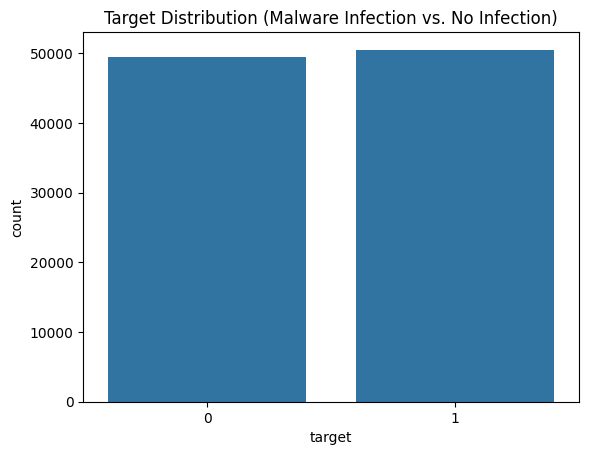

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.countplot(data=df, x='target')
plt.title('Target Distribution (Malware Infection vs. No Infection)')
plt.show()


In [ ]:
from sklearn.model_selection import train_test_split
X = df.drop(columns=['target'])   # Features
y = df['target']     # Target column
X_train, X_validation, y_train, y_validation = train_test_split(X, y, test_size=0.2, random_state=42)



In [ ]:
from xgboost import XGBRegressor
model = XGBRegressor(
    n_estimators=500,       # More trees
    learning_rate=0.05,     # Lower learning rate for better convergence
    max_depth=10,           # More depth to capture complexity
    colsample_bytree=0.8,   # Random feature selection for diversity
    subsample=0.8,          # Prevents overfitting
    reg_alpha=0.01,         # L1 Regularization
    reg_lambda=1,           # L2 Regularization
    gamma=0.1,              # Minimum loss reduction
    random_state=42
)

model.fit(X_train, y_train)
y_pred_test = model.predict(X_validation)
y_pred_train = model.predict(X_train)


ValueError: DataFrame.dtypes for data must be int, float, bool or category. When categorical type is supplied, the experimental DMatrix parameter`enable_categorical` must be set to `True`.  Invalid columns:MachineID: object, ProductName: object, EngineVersion: object, AppVersion: object, SignatureVersion: object, PlatformType: object, Processor: object, OSVersion: object, OsPlatformSubRelease: object, OSBuildLab: object, SKUEditionName: object, MDC2FormFactor: object, DeviceFamily: object, PrimaryDiskType: object, ChassisType: object, PowerPlatformRole: object, NumericOSVersion: object, OSArchitecture: object, OSBranch: object, OSEdition: object, OSSkuFriendlyName: object, OSInstallType: object, AutoUpdateOptionsName: object, OSGenuineState: object, LicenseActivationChannel: object, FlightRing: object

In [ ]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

# Evaluate the model using regression metrics
train_r2 = r2_score(y_train, y_pred_train)
test_r2 = r2_score(y_validation, y_pred_test)
mae = mean_absolute_error(y_validation, y_pred_test)
mse = mean_squared_error(y_validation, y_pred_test)

print(f"Train R²: {train_r2}")
print(f"Test R²: {test_r2}")
print(f"Mean Absolute Error: {mae}")
print(f"Mean Squared Error: {mse}")


Train R²: 0.732405960559845
Test R²: 0.07606559991836548
Mean Absolute Error: 0.44685956835746765
Mean Squared Error: 0.23094922304153442


In [ ]:
import xgboost as xgb
from xgboost import plot_importance

feature_importance = model.get_booster().get_score(importance_type="weight")
feature_importance_df = pd.DataFrame(
    list(feature_importance.items()), columns=["Feature", "Importance"]
)

# Sort features by importance
feature_importance_df = feature_importance_df.sort_values(by="Importance", ascending=False)


In [ ]:
# Set a threshold for feature importance
threshold = 1
important_features = feature_importance_df[feature_importance_df["Importance"] > threshold]["Feature"].tolist()

# Keep only important features in X_train and X_test
X_train_selected = X_train[important_features]
X_test_selected = X_validation[important_features]

print(f"Selected {len(important_features)} important features out of {X_train.shape[1]}.")


Selected 71 important features out of 75.


In [ ]:
# Re-train XGBoost model with selected features
model_selected = xgb.XGBRegressor(
    max_depth=10,  # Try reducing this if overfitting
    learning_rate=0.05,
    n_estimators=500,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)
model_selected.fit(X_train, y_train)
y_pred_test = model.predict(X_validation)
y_pred_train = model.predict(X_train)


In [ ]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

# Evaluate the model using regression metrics
train_r2 = r2_score(y_train, y_pred_train)
test_r2 = r2_score(y_validation, y_pred_test)
mae = mean_absolute_error(y_validation, y_pred_test)
mse = mean_squared_error(y_validation, y_pred_test)

print(f"Train R²: {train_r2}")
print(f"Test R²: {test_r2}")
print(f"Mean Absolute Error: {mae}")
print(f"Mean Squared Error: {mse}")


Train R²: 0.732405960559845
Test R²: 0.07606559991836548
Mean Absolute Error: 0.44685956835746765
Mean Squared Error: 0.23094922304153442


In [ ]:
test_predictions = model_selected.predict(test_data)  # Generate predictions

# Create submission DataFrame (Ensure sample_submission exists)
submission = sample_submission.copy()
submission['target'] = test_predictions  

# If classification-like labels are needed (Assuming binary case)
# Ensure model output is properly rounded or thresholded
submission['target'] = submission['target'].apply(lambda x: '1' if x > 0.5 else '0')

# Save to CSV
submission.to_csv('submission.csv', index=False)

# Output file ready for submission
print("Submission file created.")


Submission file created.
